# Compare Simple RNN vs LSTM for Stock Price Prediction on Example of GOOG stock 

### Introduction
In the dynamic world of finance, accurate stock price prediction remains a significant challenge due to market volatility, complex trends, and external influences. Leveraging advanced machine learning techniques has become increasingly vital in navigating these complexities.

With the advancement of deep learning techniques, recurrent neural networks (RNNs) have gained popularity in time series forecasting. However, traditional RNNs often struggle with long-term dependencies due to the vanishing gradient problem. Long Short-Term Memory (LSTM) networks, an advanced variant of RNNs, are specifically designed to overcome these limitations by incorporating memory cells that can retain important information over longer sequences.  

This project aims to analyze and compare the predictive capabilities of a basic RNN and an LSTM model when applied to Alphabet Inc. (GOOG) stock price data. By leveraging historical stock price data, we will train both models and evaluate their performance in capturing market trends and making accurate predictions.  

Through this comparison, we seek to highlight the strengths and weaknesses of each architecture. The insights gained from this study will help determine which model is more effective for stock price prediction and provide a deeper understanding of how neural networks process sequential financial data.

In [36]:
from datetime import datetime

import yfinance as yf

import numpy as np

from statsmodels.graphics.tsaplots import plot_acf

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM, Dropout, Input

from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import seaborn as sns

### Dataset

The initial step in our project involves acquiring and loading the stock data into memory. For this purpose, we will utilize **Yahoo Finance**. 

We will employ the **`yfinance`** library to seamlessly retrieve the data. The library provides an efficient Pythonic method for downloading market data directly from Yahoo Finance. It simplifies data acquisition and ensures that we work with accurate and up-to-date stock information. 

In [2]:
ticker_str = 'GOOG'
ticker = yf.Ticker(ticker_str)

df = ticker.history(start='2015-01-01',end=datetime.now().strftime('%Y-%m-%d'))
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2015-01-02 00:00:00-05:00,26.283640,26.395928,26.039689,26.074965,28951268,0.0,0.0
2015-01-05 00:00:00-05:00,25.997952,26.051115,25.491171,25.531414,41196796,0.0,0.0
2015-01-06 00:00:00-05:00,25.587558,25.645938,24.894459,24.939671,57998800,0.0,0.0
2015-01-07 00:00:00-05:00,25.190082,25.202206,24.824901,24.896944,41301082,0.0,0.0
2015-01-08 00:00:00-05:00,24.742424,25.015192,24.395129,24.975445,67071641,0.0,0.0
...,...,...,...,...,...,...,...
2025-02-18 00:00:00-05:00,187.440002,187.779999,183.580002,185.800003,19796000,0.0,0.0
2025-02-19 00:00:00-05:00,186.184998,187.360001,185.500000,187.130005,13120500,0.0,0.0
2025-02-20 00:00:00-05:00,186.500000,187.119995,184.600006,186.639999,12063800,0.0,0.0


### Exploratory Data Analysis & Processing

Let's take a look at the dataset 

In [3]:
df.describe()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,2551.000000,2551.000000,2551.000000,2551.000000,2.551000e+03,2551.000000,2551.000000
mean,83.990332,84.893038,83.161384,84.040865,3.059578e+07,0.000235,0.008233
std,45.970954,46.489930,45.507863,45.990248,1.535526e+07,0.006856,0.396471
min,24.576479,24.642359,24.224213,24.472139,6.809800e+06,0.000000,0.000000
25%,46.426685,46.688495,46.095872,46.426439,2.106000e+07,0.000000,0.000000
50%,65.514601,66.147330,65.021371,65.715881,2.683600e+07,0.000000,0.000000
75%,123.080259,124.398028,121.897007,122.943256,3.548950e+07,0.000000,0.000000
max,204.500000,208.699997,204.259995,207.710007,2.232980e+08,0.200000,20.000000


Are there any missing values?

In [4]:
df[df.isnull()].sum()

Open            0.0
High            0.0
Low             0.0
Close           0.0
Volume          0.0
Dividends       0.0
Stock Splits    0.0
dtype: float64

There are no missing values.

As the next step, we will build rolling average charts on top of the close price chart. Rolling average allows to estimate trends on a time series.

<Axes: xlabel='Date'>

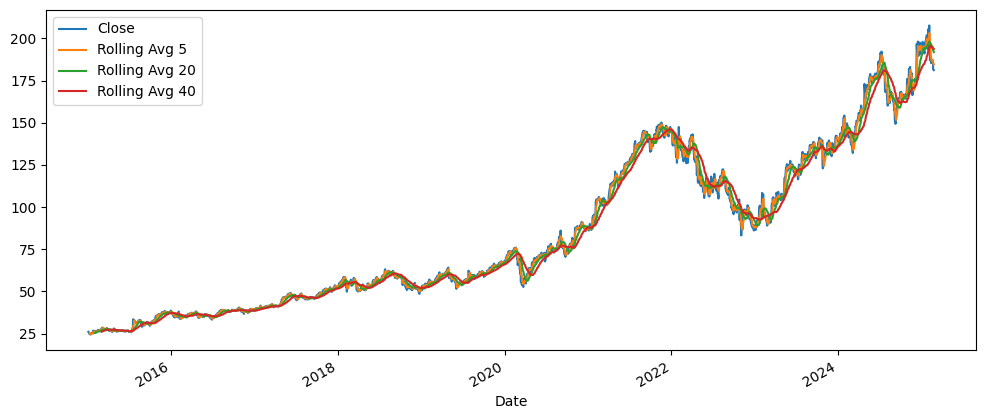

In [5]:
windows = [5, 20, 40]

for w in windows:
    column = f'Rolling Avg {w}'
    df[column] = df['Close'].rolling(w).mean()

df[['Close', 'Rolling Avg 5', 'Rolling Avg 20', 'Rolling Avg 40']].plot(figsize=(12, 5))

We wouldn't expect the stock price to be stochastic. But let's confirm it in a scientific way. For that, we need to build an Autocorrelation Function (ACF). If the process is stochastic, we would see that from some lag, the autocorrelation coefficients would lie in a blue area on the chart. 

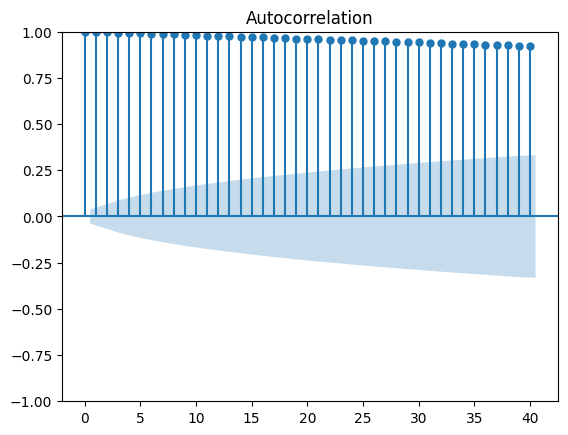

In [6]:
_ = plot_acf(df['Close'], lags=40)

* Strong dependency:
The data has a strong dependence on past values, with each observation significantly related to previous observations at any lag.
* No seasonality: No fluctuations on the ACF indicates that there is no seasonality 
* Non-stationarity:
This pattern often suggests the time series is not stationary, as a stationary series would typically show autocorrelation values declining rapidly as the lag increases. 
* Potential issues with forecasting:
When all lags are high, it can be difficult to accurately forecast future values as the current value is heavily influenced by past values across a large time window.
* High correlation with the previous day value (close to one)

Let's split the data to train and test with proportion $80:20$

Let's scale the data to be between 0 and 1. For that we can use **`MinMaxScaler`**

In [7]:
close_price = df['Close'].to_numpy()

split = int(0.8*df.shape[0])

train = close_price[:split]
test = close_price[split:]

mmScaler = MinMaxScaler()

train_sc = mmScaler.fit_transform(train.reshape(-1, 1)).reshape(-1)
test_sc = mmScaler.transform(test.reshape(-1, 1)).reshape(-1)

Because we will train our RNN and LSTM models with the Time Series, we need to convert our dataset to the predictors and target variables.

The logic is the next. We will pass through the window through the dataset and will use the next value after the window as a target variable. 

We do not need to implement this logic by ourselves. It is already implemented in **`TimeseriesGenerator`** class

In [8]:
length = 40
generator = TimeseriesGenerator(train_sc, train_sc, length=length, batch_size=8)

### Models

#### Simple RNN

A Recurrent Neural Network (RNN) is a type of artificial neural network designed for sequential data processing. Unlike traditional networks, RNNs have memory. I allow them to retain past information and recognize patterns over time. RNNs are widely used in time series forecasting. However, they struggle with long-term dependencies due to the vanishing gradient problem.

The input layer depends on the window size. We decided the SimpleRNN to be also the size of the window. 

In [9]:
rnn_model = Sequential()
rnn_model.add(Input((length, 1)))
rnn_model.add(SimpleRNN(length))
rnn_model.add(Dense(length, activation='relu'))
rnn_model.add(Dense(1, activation='relu'))
rnn_model.compile(loss='mse', optimizer='adam')

rnn_model.summary()

2025-02-25 18:13:45.850907: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2025-02-25 18:13:45.850938: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2025-02-25 18:13:45.853494: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
I0000 00:00:1740536025.853525 1493681 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1740536025.853548 1493681 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 40)             │         1,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 40)             │         1,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            41 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,361 (13.13 KB)

 Trainable params: 3,361 (13.13 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
rnn_hist = rnn_model.fit(generator, epochs=10)

Epoch 1/10


/Users/lbabich/.pyenv/versions/3.10.12/envs/py310-ml/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2025-02-25 18:13:46.317153: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


250/250 ━━━━━━━━━━━━━━━━━━━━ 115s 456ms/step - loss: 0.0193
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 109s 438ms/step - loss: 6.6324e-04
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 109s 437ms/step - loss: 5.8690e-04
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 110s 438ms/step - loss: 6.8036e-04
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 109s 436ms/step - loss: 0.0216
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 109s 437ms/step - loss: 3.5035e-04
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 109s 435ms/step - loss: 3.5900e-04
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 109s 435ms/step - loss: 3.9885e-04
Epoch 9/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 109s 434ms/step - loss: 2.1996e-04
Epoch 10/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 109s 436ms/step - loss: 2.6257e-04


#### LSTM

A Long Short-Term Memory (LSTM) network is an advanced type of Recurrent Neural Network (RNN) designed to handle long-term dependencies in sequential data. It uses memory cells, along with input, output, and forget gates.

LSTMs are widely used in time series forecasting, overcoming RNNs’ vanishing gradient problem.

Here, the input layer also depends on the window size. We decided the first LSTM layer to be also the size of the window. The second LSTM layer will be twice as small.

The architecture we will use is the following:

In [24]:
lstm_model = Sequential()
lstm_model.add(Input((length, 1)))
lstm_model.add(LSTM(length, return_sequences=True))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(int(length/2), return_sequences=False))
lstm_model.add(Dense(int(length/2), activation='relu'))
lstm_model.add(Dense(1, activation='relu'))
lstm_model.compile(loss='mse', optimizer='adam')

lstm_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 40, 40)         │         6,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 40, 40)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 20)             │         4,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,041 (47.04 KB)

 Trainable params: 12,041 (47.04 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
lstm_hist = lstm_model.fit(generator, epochs=20)

Epoch 1/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 0.0188
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 0.0018
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 9.9629e-04
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 0.0012
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 0.0010
Epoch 6/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 0.0013
Epoch 7/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 0.0011
Epoch 8/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 9.3445e-04
Epoch 9/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 7.1757e-04
Epoch 10/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 7.0762e-04
Epoch 11/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 7.8159e-04
Epoch 12/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 6.5744e-04
Epoch 13/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 6.5000e-04
Epoch 14/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 7.1886e-04
Epoch 15/20

In [26]:
lstm_model.predict(train_sc[9:9+length].reshape(1,length,1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step


array([[0.03064556]], dtype=float32)

### Evaluation

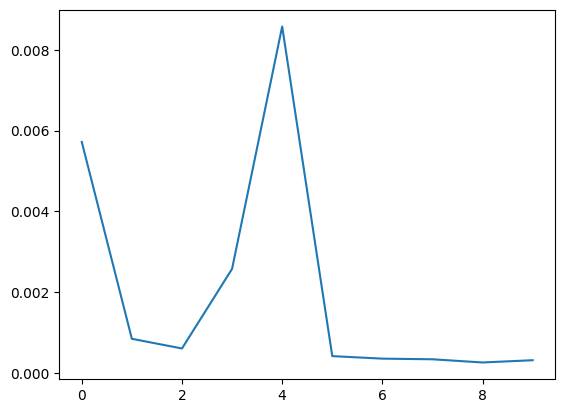

In [27]:
plt.plot(rnn_hist.history['loss'], label='loss')

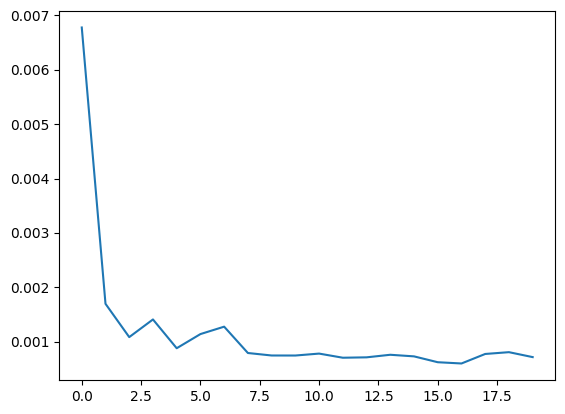

In [28]:
plt.plot(lstm_hist.history['loss'], label='loss')

In terms of MSE for train data, RNN shows better results. It is around 2 times better.

Further, we will perform a visual analysis of the prediction based on the test dataset.

In [29]:
rnn_res = []
for i in range(len(test_sc)-length):
    rnn_res.append(rnn_model.predict(test_sc[i:i+length].reshape(1,length,1), verbose=0))
    if i%100==0:
        print(f"{100*i/(len(test_sc)-length)}% predicted")
print("100.0% predicted")

0.0% predicted
21.231422505307854% predicted
42.46284501061571% predicted
63.69426751592356% predicted
84.92569002123142% predicted
100.0% predicted


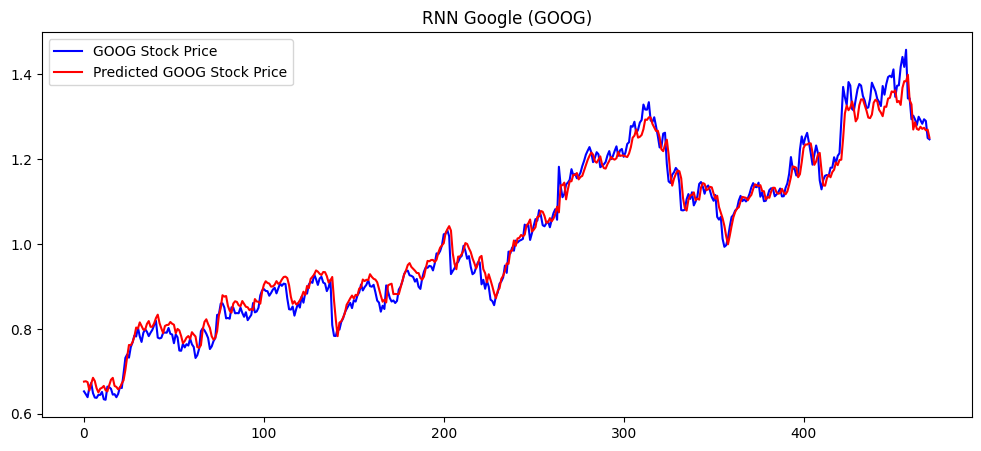

In [30]:
plt.figure(figsize=(12,5))
plt.plot(test_sc[length:], color = 'blue', label = 'GOOG Stock Price')
plt.plot([r.reshape(-1)[0] for r in rnn_res], color = 'red', label = 'Predicted GOOG Stock Price')
plt.title('RNN Google (GOOG)')
plt.legend()
plt.show()

In [31]:
lstm_res = []
for i in range(len(test_sc)-length):
    lstm_res.append(lstm_model.predict(test_sc[i:i+length].reshape(1,length,1), verbose=0))
    if i%100==0:
        print(f"{100*i/(len(test_sc)-length)}% predicted")
print("100.0% predicted")

0.0% predicted
21.231422505307854% predicted
42.46284501061571% predicted
63.69426751592356% predicted
84.92569002123142% predicted
100.0% predicted


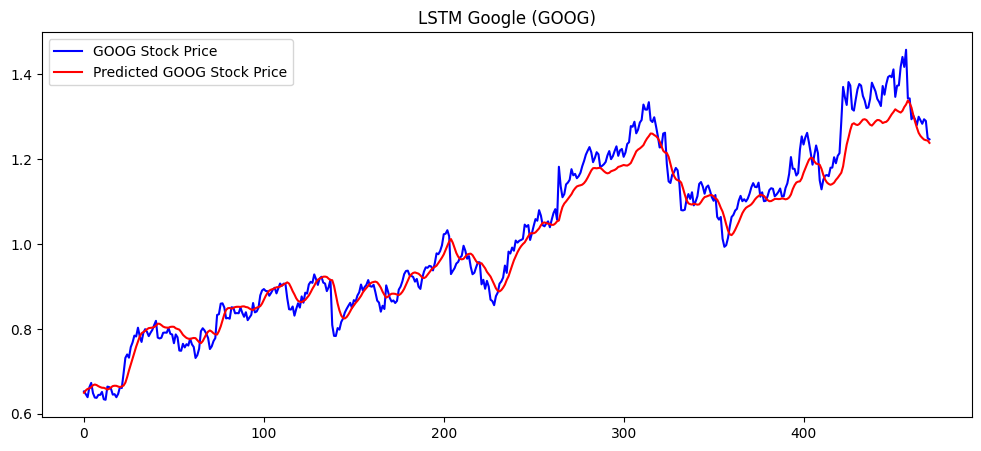

In [32]:
plt.figure(figsize=(12,5))
plt.plot(test_sc[length:], color = 'blue', label = 'GOOG Stock Price')
plt.plot([r.reshape(-1)[0] for r in lstm_res], color = 'red', label = 'Predicted GOOG Stock Price')
plt.title('LSTM Google (GOOG)')
plt.legend()
plt.show()

Again, RNN looks better than LSTM. It looks like the predicted values are closer to the real ones. But was RNN able to capture the trend?

Here will will do the next. We will predict not only the next day but 10 consecutive days and plot them on top of the real stock price

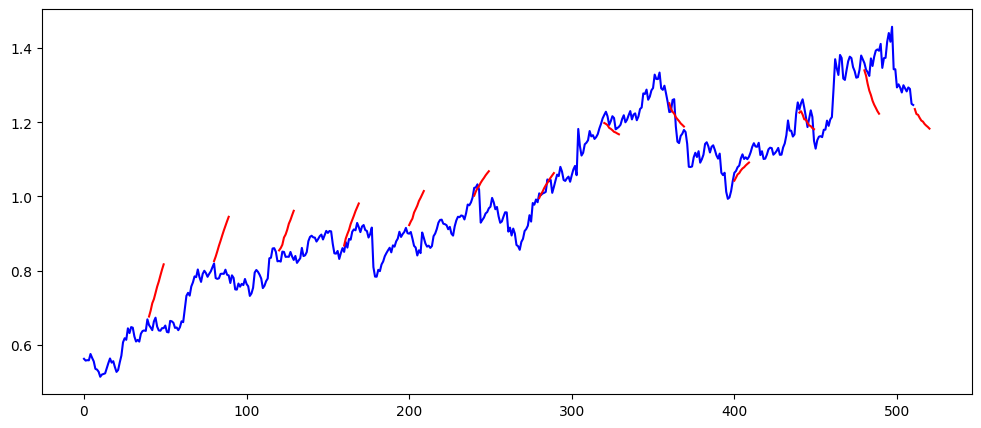

In [33]:
plt.figure(figsize=(12,5))
plt.plot(range(len(test_sc)),test_sc, color = 'blue', label = 'GOOG Stock Price')
for base in range(0, len(test_sc), 40):
    if len(test_sc) - base < 40:
        base = len(test_sc) - 40
    curr = test_sc[base:base+length] 
    res=[]
    for i in range(10):
        r = rnn_model.predict(curr.reshape(1,length,1), verbose=0)
        res.append(r.reshape(-1)[0])
        curr = np.append(curr, r.reshape(-1)[0])
        curr = np.delete(curr, 0)    
    plt.plot(range(base+length, base+length+10),[r.reshape(-1)[0] for r in res], color = 'red', label = 'RNN Predicted GOOG Stock Price')
plt.show()

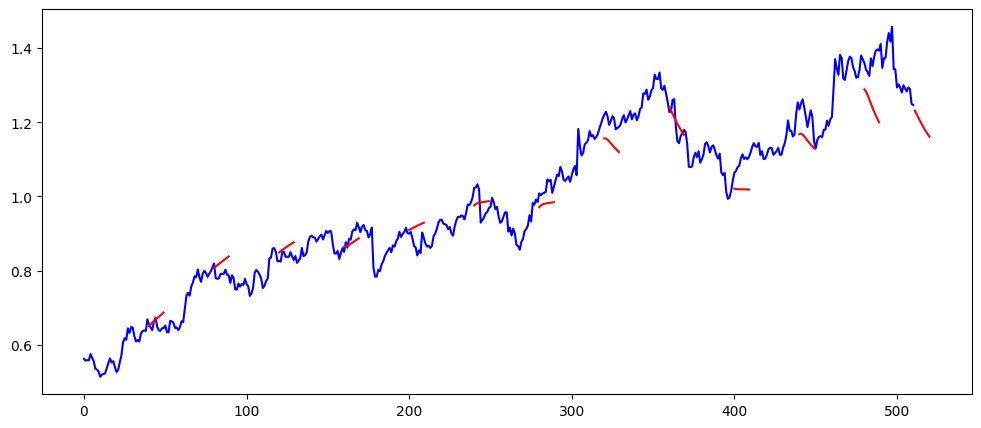

In [34]:
plt.figure(figsize=(12,5))
plt.plot(range(len(test_sc)),test_sc, color = 'blue', label = 'GOOG Stock Price')
for base in range(0, len(test_sc), 40):
    if len(test_sc) - base < 40:
        base = len(test_sc) - 40
    curr = test_sc[base:base+length] 
    res=[]
    for i in range(10):
        r = lstm_model.predict(curr.reshape(1,length,1), verbose=0)
        res.append(r.reshape(-1)[0])
        curr = np.append(curr, r.reshape(-1)[0])
        curr = np.delete(curr, 0)
    plt.plot(range(base+length, base+length+10),[r.reshape(-1)[0] for r in res], color = 'red', label = 'LSTM Predicted GOOG Stock Price')
plt.show()

Now, we can easily see that LSTM outperforms basic RNN. It was able to capture the trend and more significantly more accurately predict the stock price for 10 consecutive days compared to the simple RNN

### Conlusion

This project demonstrated a comparative analysis of Simple RNN and LSTM models for stock price prediction using GOOG stock data. The results clearly indicate that LSTM outperforms the basic RNN in capturing market trends and making more accurate predictions over a 10-day period.  

LSTM’s ability to retain long-term dependencies and mitigate the vanishing gradient problem gives it a significant advantage over traditional RNNs. The basic RNN models struggle with maintaining relevant information over extended sequences. 

Overall, this study reinforces the importance of choosing the right neural network architecture for financial time series prediction. Simple RNNs can capture short-term patterns, while LSTMs provide a more reliable solution for capturing long time trends. It makes LSTM a preferred choice for market analysis and forecasting applications.